In [41]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# prepare data

In [21]:
# currently trained only on 'clath_aux+gak_a7d2_new'
# dsets = ['clath_aux+gak_new']
dsets = ['clath_aux_dynamin']
splits = ['test']
# feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
print('type', type(dfs))
# load model
p = 1
results = pkl.load(open('../models/dnn_full_long_normalized_across_track_1_feat_dynamin.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
# df = dfs[('clath_aux+gak_new', 'test')]
df = dfs[list(dfs.keys())[0]]
X = df[feat_names[:p]]
y = df['y_consec_thresh']

100%|██████████| 1/1 [00:20<00:00, 20.84s/it]

type <class 'dict'>


# prediction plots

In [22]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
# df = dfs[('clath_aux+gak_new', 'test')]
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df['y_consec_thresh'].values
preds = dnn.predict(x)
n = df.shape[0]

m = 40
xtrack_unnormalized = df[track_name_unnormalized]
xtrack = x[track_name]
xtrack_t = torch.tensor(np.array(list(xtrack.values)), dtype=torch.float)
xfeats = x[[c for c in x.columns if c != track_name]]
xfeats_t = torch.tensor(np.array(xfeats).astype(float), dtype=torch.float)


# sort things
print('acc', np.mean((preds > 0) == y))

acc 0.78926487747958


# scatter plots

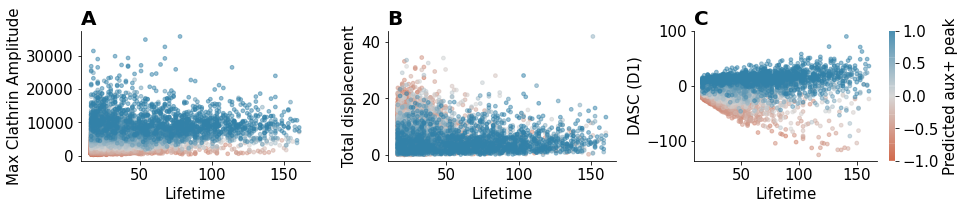

In [13]:
R, C = 1, 3
vabs = max(abs(df['preds'])) // 2
norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
kwargs = dict(
    cmap=viz.cmap,
    norm=norm,
    alpha=0.5,
    s=14, edgecolors=None
)
plt.figure(figsize=(C * 4.5, R * 3))
plt.subplot(R, C, 1)
plt.scatter(df['lifetime'], df['X_max'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('Max Clathrin Amplitude')
plt.title('A', loc='left', fontweight='bold')

plt.subplot(R, C, 2)
plt.scatter(df['lifetime'], df['mean_total_displacement'] * df['lifetime'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('Total displacement')
plt.title('B', loc='left', fontweight='bold')

plt.subplot(R, C, 3)
plt.scatter(df['lifetime'], df['X_d1'] * df['lifetime'], c=df['preds'], **kwargs)
plt.xlabel('Lifetime')
plt.ylabel('DASC (D1)')
plt.title('C', loc='left', fontweight='bold')
cb = plt.colorbar(label='Predicted aux+ peak')
cb.outline.set_visible(False)
viz.savefig('top_feats_scatter')

# viz errs

In [ ]:
y = df['y_consec_thresh'].astype(bool)
p = df['preds'].values > 0

tp = y & p
tn = ~y & ~p
fp = ~y & p
fn = y & ~p
print('fracs', 'fp', fp.sum() / y.size, 'fn', fn.sum() / y.size)
for idxs, name in zip([fp, fn], ['fp', 'fn']):    
    d = df[idxs]
    errs = viz.viz_biggest_errs(d, None, None, d['y_consec_thresh'],
                                d['preds'] > 0, d['preds'],
                                show_track_num=False,
                                plot_z=True,
                                lifetime_max=100,
                                text_labels=idxs is fn)
    viz.savefig(name)

# correcting labels

In [ ]:
for idxs, name in zip([fp, fn], ['fp', 'fn']):    
    d = df[idxs]
    errs = viz.viz_biggest_errs(d, None, None, d['y_consec_thresh'],
                                d['preds'] > 0, d['preds'],
                                plot_z=True,
#                                 lifetime_max=100,
                                sort_by_residuals=False,
                                show_track_num=True,
                                num_to_plot=idxs.sum(),
                               )
    plt.savefig(name + '.pdf')
#     viz.savefig(name)

In [50]:
pos_fp = np.array([
    2, 5, 6, 7, 8, 9, 12, 13, 14, 16, 18, 19, 21, 32, 36, 37, 38, 39, 43, 44, 52, 56, 59, 71, 72, 76, 80, 81, 97, 98,
    108, 109, 111, 120, 122, 126, 129, 138, 165, 166, 168, 183, 185, 195, 202, 216, 224, 225, 232, 242, 243, 244, 246,
    247, 261, 268, 279, 288, 294, 308, 324, 326, 327, 340, 342, 345, 346, 365, 378, 380, 396, 401, 425, 440, 447, 485,
    495, 512, 541, 544, 576, 612, 620, 625, 632, 649, 654, 663, 665, 666, 672, 688, 699, 706, 707, 717, 734, 745, 771,
    816, 837, 846, 851, 857, 874, 876, 887, 893, 896, 903, 910, 935, 951, 964, 975, 982, 990, 998, 1000, 1006, 1011,
    1015, 1019, 1021, 1023, 1030, 1031, 1036, 1039, 1045, 1050, 1058, 1061, 1063, 1064, 1070, 1071, 1082, 1086, 1093,
    1095, 1099, 1110, 1113, 1118, 1122, 1126, 1127, 1132, 1143, 1150, 1152, 1155,
])

hotspots_fp = np.array([
    25, 58, 69, 70, 73, 91, 105, 106, 107, 141, 142, 145, 151, 161, 162, 164, 172, 218, 234, 241, 254, 277, 297, 317,
    320, 338, 341, 362, 363, 364, 373, 390, 411, 415, 473, 474, 523, 524, 539, 556, 571, 572, 603, 604, 606, 608, 611,
    613, 621, 624, 638, 639, 640, 648, 676, 679, 686, 692, 702, 703, 715, 743, 744, 762, 774, 775, 777, 781, 786, 790,
    795, 801, 805, 811, 820, 822, 828, 832, 839, 841, 853, 854, 860, 861, 866, 870, 881, 886, 894, 897, 906, 916, 922,
    936, 940, 941, 949, 958, 965, 972, 974, 977, 980, 984, 986, 987, 992, 994, 996, 1001, 1005, 1010, 1013, 1014, 1017,
    1026, 1035, 1037, 1038, 1052, 1053, 1072, 1075, 1078, 1081, 1085, 1087, 1088, 1089, 1092, 1094, 1096, 1097, 1100,
    1101, 1102, 1104, 1107, 1111, 1112, 1114, 1115, 1119, 1120, 1121, 1123, 1124, 1129, 1134, 1145, 1146, 1148, 1154,
])

In [ ]:
d_fp = df[fp]
d = d_fp.iloc[po]
errs = viz.viz_biggest_errs(d, None, None, d['y_consec_thresh'],
                            d['preds'] > 0, d['preds'],
                            plot_z=True,
                            sort_by_residuals=False,
                            num_to_plot=25
                           )

In [54]:
d.pid.values

array([205537, 215233, 216903, 216241, 236608, 216941, 208591, 223088,
       217357, 214308, 237087, 247979, 207586, 216892, 217105, 213597,
       225263, 214879, 222906, 245501, 247460, 217602, 207269, 215196,
       216337, 245702, 224723, 245320, 213849, 209150, 226611, 248664,
       255361, 249998, 215481, 204719, 214674, 214432, 205126, 205146,
       218024, 206783, 225708, 247813, 255434, 208411, 212022, 212829,
       243765, 224915, 214699, 243846, 219117, 214503, 214622, 212061,
       208072, 243264, 213813, 228133, 224472, 247999, 213403, 208150,
       242500, 222445, 217523, 207271, 206599, 204323, 245793, 213013,
       218184, 216085, 236403, 208438, 246518, 225456, 216652, 245564,
       234101, 222997, 245241, 215456, 234109, 207612, 246110, 236069,
       204970, 225392, 235906, 212937, 234456, 246400, 225547, 213433,
       241137, 224283, 215557, 218920, 245648, 215118, 231402, 227704,
       235268, 242653, 254434, 244044, 229557, 246020, 204639, 223538,
      